# Vehicle Detection and Tracking Pipeline

## Goal

Create a pipeline that can process video frame by frame to detect and track the vehicles in each image. The output of the project should be bounding boxes overlaid on each image, thereby modifying the video frame by frame. 


### Our Approach:

1.Read provided training images. 

2.Split the images into test and training images

3.Extract features from each image that can be used to classify car vs others

4.Train a classifier on images

5.Implement sliding window technique to detect all the vehicles in the image

6.Create a pipeline to read frames of video and overlay bouding boxes across cars

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import os
import re
from glob import glob
from shutil import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
import pdb
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

In [2]:
## Defining the path for folders containing images

ROOT = "D:/SelfDriving/Term1/Project5/CarND-Vehicle-Detection/"

carpath = ROOT+"vehicles/"

non_carpath = ROOT+"non-vehicles/"

In [3]:
#Creating a list of directories containing the car and non car images
direcs = os.listdir("vehicles/")

nondirecs = os.listdir("non-vehicles/")

In [4]:
#removing the driectories that don't containing images
direcs = [d for d in direcs if not re.search("^\..*",d)]
nondirecs = [d for d in nondirecs if not re.search("^\..*",d)]

In [5]:
#creating array containing full name of the car images
car_training = []
total_count=0
for d in direcs:
    temp = carpath+d
    imgs = glob(temp+"/*.png")
    total_count+=len(imgs)
    car_training.extend([re.sub("\\\\","/",i) for i in imgs])
        
            

In [6]:
#creating array containing full name of the noncar images

noncar_training = []
total_count=0
for d in nondirecs:
    temp = non_carpath+d
    imgs = glob(temp+"/*.png")
    total_count+=len(imgs)
    noncar_training.extend([re.sub("\\\\","/",i) for i in imgs])
        
            

In [7]:
#creating target variable (1 for car and 0 for non car) corresponding to each image
y_car = np.ones((len(car_training)))
y_ncar = np.zeros((len(noncar_training)))

In [8]:
#concatenating the target variables into single target variable
y = np.hstack((y_car,y_ncar))

In [9]:
#concatenating image paths into a single input array
x = np.hstack((car_training,noncar_training))

In [10]:
x.shape,y.shape

((17760,), (17760,))

In [14]:
#splitting the data into train and test dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,shuffle=True)


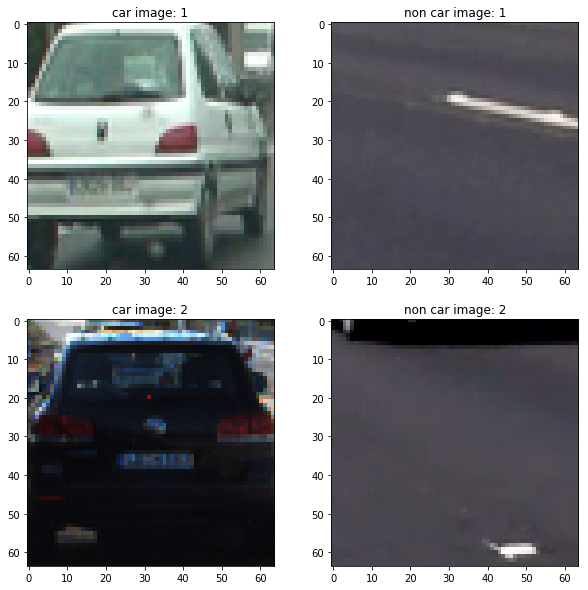

In [15]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
car_data = x_train[y_train==1]
noncar_data = x_train[y_train==0]
car_paths = np.random.choice(car_data,2)
ncar_paths = np.random.choice(noncar_data,2)
for i,ax in enumerate(axs.flat):
    if i%2==0:
        #print(car_paths[i//2])
        ax.imshow(mpimg.imread(car_paths[i//2]))
        ax.set_title('car image: {}'.format(str(i//2+1)))
    else:
        #print(ncar_paths[i//2])
        ax.imshow(mpimg.imread(ncar_paths[i//2]))
        ax.set_title('non car image: {}'.format(str(i//2+1)))

plt.savefig('carsandnoncars.jpg')


## Feature Extraction

Having collated all the data and having split the data into training and test dataset, we will now extract the features for classification. We will try to extract different kinds of features from images including HOG, color histograms and spatial bins. Extracting different kinds of features will help us classify the car vs non cars. 
But before extracting the features, we will explore different color spaces to figure out which color space can help with the identification of car vx non car

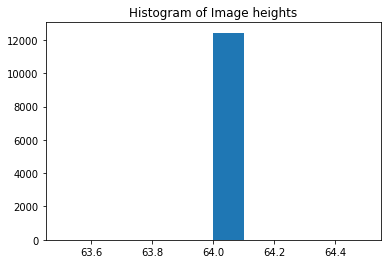

In [16]:
#histogram of the height of the images
plt.hist([cv2.imread(i).shape[1] for i in x_train])
plt.title("Histogram of Image heights")
plt.savefig("Hist_height.png")
plt.show()



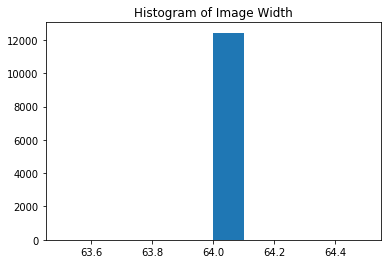

In [17]:
#histogram of the width of the images

plt.hist([cv2.imread(i).shape[0] for i in x_train])
plt.title("Histogram of Image Width")
plt.savefig("Hist_width.png")
plt.show()

In [18]:


def plot3D(img,colors,axis_label="RGB",axis_limits=((0,255),(0,255),(0,255))):
    """function to plot each channel of the images in 3d graph"""
    fig = plt.figure(figsize=(8,8))
    ax=Axes3D(fig)
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    
    ax.set_xlabel(axis_label[0],fontsize=16,labelpad=16)
    ax.set_ylabel(axis_label[1],fontsize=16,labelpad=16)
    ax.set_zlabel(axis_label[2],fontsize=16,labelpad=16)
    
    ax.scatter(img[:,:,0].ravel(),img[:,:,1].ravel(),img[:,:,2].ravel(),c=colors,edgecolors=None,)

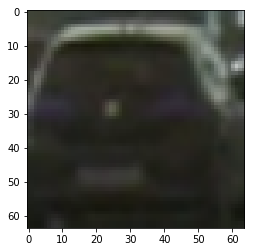

In [19]:
test_img = cv2.imread(car_training[500])
new_img=cv2.cvtColor(test_img,cv2.COLOR_BGR2HLS)
plt.imshow(test_img)

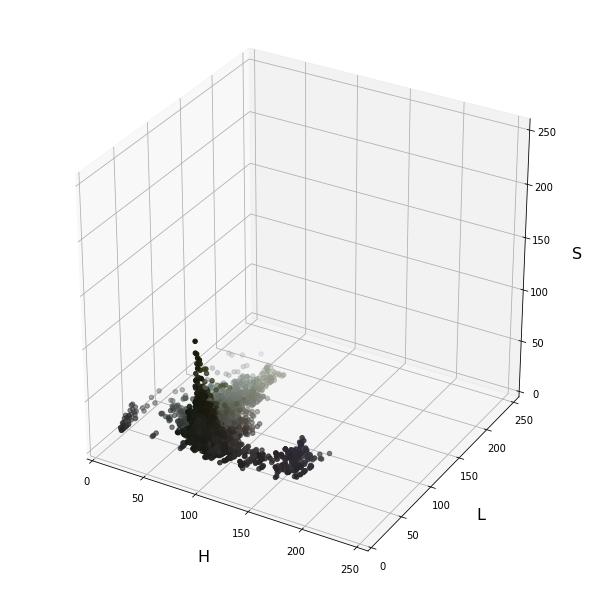

In [20]:
colors = test_img/255.
colors = colors.reshape((-1,3))
plot3D(new_img,colors,axis_label="HLS")

In [21]:
def spatial_bining(img,size=(32,32)):
    return cv2.resize(img,size).ravel()

In [22]:
def color_hist(img,nbins=32,bins_range=(0,255)):      
    h1 = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    h2 = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    h3 = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    return np.concatenate((h1[0],h2[0],h3[0]))

In [23]:
def get_hog_features(img,orient,pixels_per_cell=(8,8),cells_per_block=(2,2),feature_vec=False,vis=False):
    return hog(img,orientations=orient,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,feature_vector=feature_vec,block_norm='L2-Hys',transform_sqrt=True,visualise=vis)
    

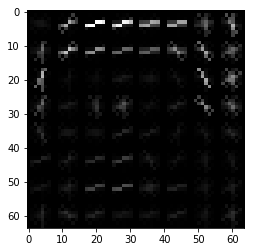

In [24]:
plt.imshow(get_hog_features(test_img[:,:,1],9,vis=True)[1],cmap='gray')

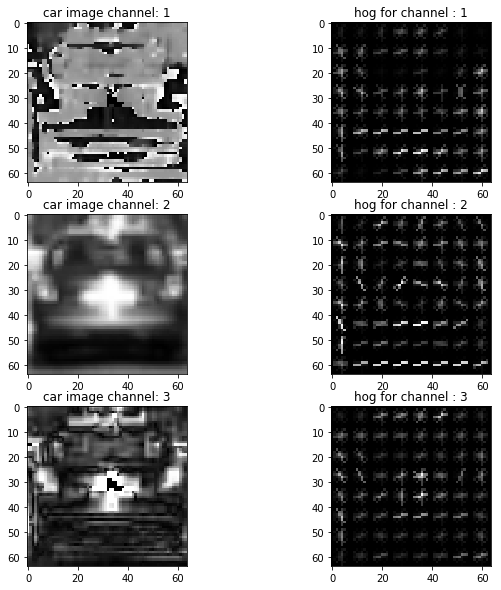

In [25]:
#Plotting a car image and its hog image channel by channel

fig,axs = plt.subplots(3,2,figsize=(10,10))
img = cv2.imread(np.random.choice(car_data,1)[0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
for i,ax in enumerate(axs.flat):
    if i%2==0:
        last_image = img[:,:,i//2]
        ax.set_title("car image channel: {}".format(str(i//2+1)))
        ax.imshow(last_image,cmap='gray')
        
    else:
        hog_img = get_hog_features(last_image,9,vis=True)
        ax.imshow(hog_img[1],cmap='gray')
        ax.set_title('hog for channel : {}'.format(str(i//2+1)))

plt.savefig('carandhog.jpg')


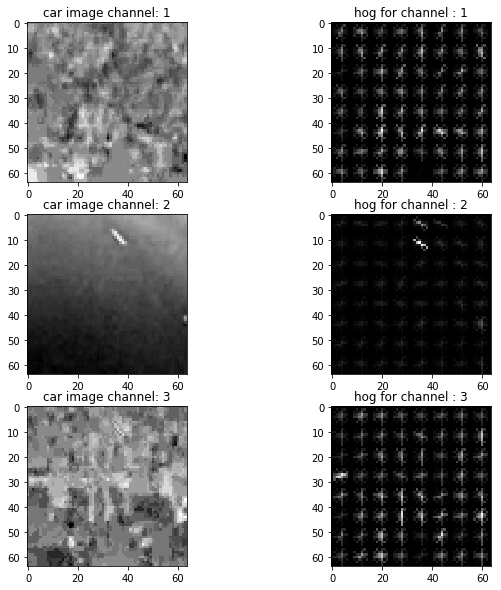

In [26]:
#Plotting a non car image and its hog image channel by channel

fig,axs = plt.subplots(3,2,figsize=(10,10))
img = cv2.imread(np.random.choice(noncar_data,1)[0])
img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
for i,ax in enumerate(axs.flat):
    if i%2==0:
        last_image = img[:,:,i//2]
        ax.set_title("car image channel: {}".format(str(i//2+1)))
        ax.imshow(last_image,cmap='gray')
        
    else:
        hog_img = get_hog_features(last_image,9,vis=True)
        ax.imshow(hog_img[1],cmap='gray')
        ax.set_title('hog for channel : {}'.format(str(i//2+1)))

plt.savefig('noncarandhog.jpg')


In [27]:
def extract_features(data,path=True,orient=9,colspace='HLS',img_size=(32,32),nbins=32,bins_range=(0,255),pixels_per_cell=(8,8),cells_per_block=(2,2)):
    features=[]
    for d in data:
        if path: img = cv2.imread(d)
        if colspace=="HLS":
            new = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
        elif colspace=="RGB":
            new = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        elif colspace =="LUV":
            new = cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
        elif colspace == "HSV":
            new = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
        elif colspace == "YCbCr":
            new = cv2.cvtColor(img,cv2.COLOR_BGR2YCbCr)
            
        else:
            new = np.copy(img)  
        sf = spatial_bining(new,size=img_size)
        cf = color_hist(new,nbins=nbins,bins_range=bins_range)
        hf1 = get_hog_features(new[:,:,0],orient,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block)
        hf2 = get_hog_features(new[:,:,1],orient,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block)
        hf3 = get_hog_features(new[:,:,2],orient,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block)
        features.append(np.concatenate((sf,cf,hf1.ravel(),hf2.ravel(),hf2.ravel())))
    return features
    
    

## Classifier(Tuning and Training) 

We will now use the function developed above for feature extractions of each image and then, we will tune and train the classifier. We will be using RandomForestClassifier. we will tune the n_estimators and max_depth hyper parameter of the classifier using its oob_score_(out of bag score). The oob_score_ is a good alternative for cross validation score.

In [28]:
feat_train = extract_features(x_train,pixels_per_cell=(8,8),cells_per_block=(2,2))

feat_test = extract_features(x_test,pixels_per_cell=(8,8),cells_per_block=(2,2))

train = np.vstack(feat_train)
test = np.vstack(feat_test)

scaler = StandardScaler()

scaler.fit(train)

train = scaler.transform(train)

test = scaler.transform(test)

In [29]:
nest_training_scores =[]
nest_oob_scores=[]

nests = [20,40,60,100]

In [30]:
for e in nests:
    clf = RandomForestClassifier(n_estimators=e,oob_score=True)
    clf.fit(train,y_train)
    nest_training_scores.append(accuracy_score(y_train,clf.predict(train)))
    nest_oob_scores.append(clf.oob_score_)
    

C:\Users\a0393637\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\a0393637\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


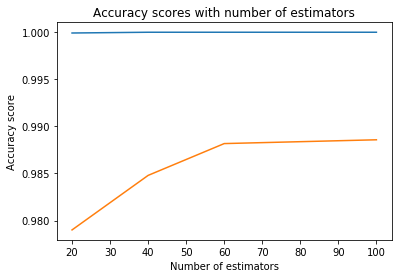

In [37]:
plt.plot(nests,nest_training_scores)
plt.plot(nests,nest_oob_scores)
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy score")
plt.title("Accuracy scores with number of estimators")
plt.show()


In [39]:
dep_training_scores =[]
dep_oob_scores=[]

dep = [3,5,10,None]

In [40]:
for d in dep:
    clf = RandomForestClassifier(n_estimators=100,oob_score=True,max_depth=d)
    clf.fit(train,y_train)
    dep_training_scores.append(accuracy_score(y_train,clf.predict(train)))
    dep_oob_scores.append(clf.oob_score_)
    

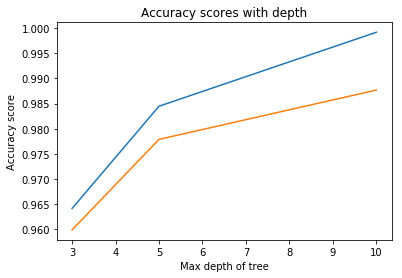

In [41]:
plt.plot(dep,dep_training_scores)
plt.plot(dep,dep_oob_scores)
plt.xlabel("Max depth of tree")
plt.ylabel("Accuracy score")
plt.title("Accuracy scores with depth")
plt.show()


### Analysis

From the above plots, it was clear that number of estimators as 100 with max depth=None was the best options

In [42]:
clf = RandomForestClassifier(n_estimators=100,oob_score=True)

In [43]:
%time clf.fit(train,y_train)

Wall time: 3min


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [44]:
%time accuracy_score(y_train,clf.predict(train))

Wall time: 899 ms


1.0

In [45]:
clf.oob_score_

0.98809523809523814

In [46]:
%time accuracy_score(y_test,clf.predict(test))

Wall time: 656 ms


0.9878003003003003

##  Sliding Window implementation

In [49]:
test_image = mpimg.imread("D:/SelfDriving/Term1/Project5/CarND-Vehicle-Detection/test_images/test1.jpg")

In [55]:
def search_multi(img,window_params,clf,scaler,orient=9,cells_per_block=2,pix_per_cell=8,spatial_size=(32,32),hist_bins=32,demo=False):
    """
    function to search for cars with different scale windows
    It takes list of dictionary elements with each element containing scale alng with
    y_start and y_stop for that window search 
    """
    img_tosearch = np.copy(img)
    conv_image = cv2.cvtColor(img_tosearch,cv2.COLOR_RGB2HLS)
    bboxes = []
    window = 64
    #pdb.set_trace()
    for p in window_params:
        #reading window parameters and the search area for this window type
        #pdb.set_trace()
        scale = p["scale"]
        y_start = np.int(p["ystart"]/scale)
        y_stop  = np.int(p["ystop"]/scale)
        #selecting image to search over
        
        
        isearch_raw = cv2.resize(conv_image,(np.int(conv_image.shape[1]/scale),np.int(conv_image.shape[0]/scale)))
        isearch = isearch_raw[y_start:y_stop,:,:]
        
        #calculating the number of blocks in x and y direction
        ishape = isearch.shape
        nxblocks = ishape[1]//pix_per_cell - cells_per_block +1
        nyblocks = ishape[0]//pix_per_cell - cells_per_block +1
        
        nblocks_wind_x = window//pix_per_cell - cells_per_block + 1
        nblocks_wind_y = window//pix_per_cell - cells_per_block + 1
        cells_per_step = 2
        # calculatig number of steps to take in each direction
        nxsteps = (nxblocks-nblocks_wind_x)//cells_per_step + 1
        nysteps = (nyblocks-nblocks_wind_y)//cells_per_step + 1
        
        #get gradient features once for the selected image
        hog1 = get_hog_features(isearch[:,:,0],orient)
        hog2 = get_hog_features(isearch[:,:,1],orient)
        hog3 = get_hog_features(isearch[:,:,2],orient)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = cells_per_step*yb
                xpos = cells_per_step*xb
                #extract hog features for each position
                hog1_filt = hog1[ypos:ypos+nblocks_wind_y,xpos:xpos+nblocks_wind_x].ravel()
                hog2_filt = hog2[ypos:ypos+nblocks_wind_y,xpos:xpos+nblocks_wind_x].ravel()
                hog3_filt = hog3[ypos:ypos+nblocks_wind_y,xpos:xpos+nblocks_wind_x].ravel()
                hog_filt = np.hstack((hog1_filt,hog2_filt,hog3_filt))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                #select the sub image under the window
                subimg = cv2.resize(isearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                
                # Get color features
                spatial_features = spatial_bining(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_filt)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = clf.predict(test_features)
                
                if test_prediction==1 and demo==False:
                    xlmap = np.int(xleft*scale)
                    ytmap = np.int(ytop*scale)
                    wmap = np.int(window*scale)
                    ysmap = np.int(y_start*scale)
                    bboxes.append([(xlmap,xlmap+wmap),(ytmap+ysmap,ytmap+ysmap+wmap)])
                elif demo==True:
                    xlmap = np.int(xleft*scale)
                    ytmap = np.int(ytop*scale)
                    wmap = np.int(window*scale)
                    ysmap = np.int(y_start*scale)
                    bboxes.append([(xlmap,xlmap+wmap),(ytmap+ysmap,ytmap+ysmap+wmap)])                   
    return bboxes
            

In [58]:
# for demonstration of windows used for searching
bboxes = search_multi(test_image,[{"scale":1,"ystart":0,"ystop":600},{"scale":2,"ystart":0,"ystop":700}],clf,scaler,pix_per_cell=8,demo=True)

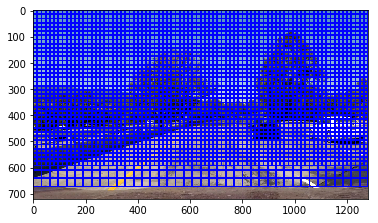

In [60]:
new = np.copy(test_image)
for bbox in bboxes:
    cv2.rectangle(new,(bbox[0][0],bbox[1][0]),(bbox[0][1],bbox[1][1]),(0,0,255),6)
plt.imshow(new)
plt.savefig('search_windows.png')

In [61]:
bboxes = search_multi(test_image,[{"scale":1,"ystart":300,"ystop":600},{"scale":2,"ystart":300,"ystop":700}],clf,scaler,pix_per_cell=8)

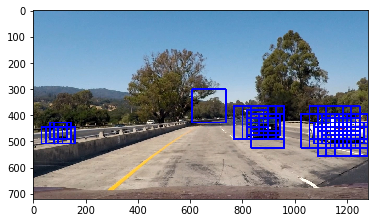

In [64]:
new = np.copy(test_image)
for bbox in bboxes:
    cv2.rectangle(new,(bbox[0][0],bbox[1][0]),(bbox[0][1],bbox[1][1]),(0,0,255),6)

plt.imshow(new)
plt.savefig('test_image_out.png')

In [68]:
test_image = mpimg.imread("D:/SelfDriving/Term1/Project5/CarND-Vehicle-Detection/test_images/test3.jpg")

In [70]:
bboxes = search_multi(test_image,[{"scale":1,"ystart":300,"ystop":600},{"scale":2,"ystart":300,"ystop":700}],clf,scaler,pix_per_cell=8)

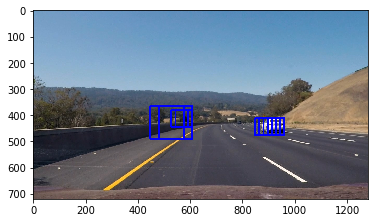

In [71]:
new = np.copy(test_image)
for bbox in bboxes:
    cv2.rectangle(new,(bbox[0][0],bbox[1][0]),(bbox[0][1],bbox[1][1]),(0,0,255),6)

plt.imshow(new)
plt.savefig('test_image2_out.png')

## Filtering and bounding box prediction 

In [77]:
def add_heatmap(img,bboxes,prior=False):
    """function to add heatmap of detection """
    if not prior: heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    for bbox in bboxes:
        heatmap[bbox[1][0]:bbox[1][1],bbox[0][0]:bbox[0][1]]+=1
    return heatmap

In [72]:
def apply_thresh(heat,thresh):
    """function to apply threshold on the heatmap"""
    heat[heat<=thresh] =0
    return heat

In [73]:
def draw_labelled_boxes(img,labels,heat):
    """function to draw the bounding boxes using filtered heatmap and output of label"""
    cimg = np.copy(img)
    ncars = labels[1]
    for c in range(1,ncars+1):
        nonz = (labels[0]==c).nonzero()
        nony = np.array(nonz[0])
        nonx = np.array(nonz[1])
        
        bbox = [(np.min(nonx),np.max(nony)),(np.max(nonx),np.min(nony))]
        cv2.rectangle(cimg,bbox[0],bbox[1],(0,0,255),6)
    return cimg
    
        
        

In [92]:
test_image = mpimg.imread("D:/SelfDriving/Term1/Project5/CarND-Vehicle-Detection/test_images/test1.jpg")
bboxes = search_multi(test_image,[{"scale":1,"ystart":300,"ystop":600},{"scale":2,"ystart":300,"ystop":700}],clf,scaler,pix_per_cell=8)


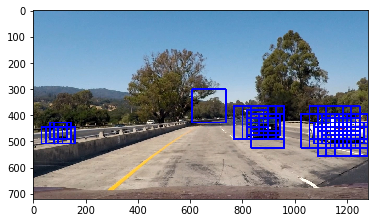

In [93]:
 new = np.copy(test_image)
for bbox in bboxes:
    cv2.rectangle(new,(bbox[0][0],bbox[1][0]),(bbox[0][1],bbox[1][1]),(0,0,255),6)

plt.imshow(new)


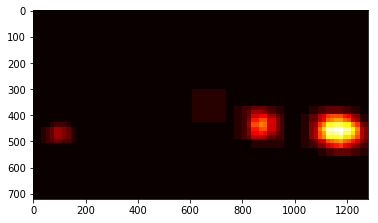

In [101]:
heat = add_heatmap(new,bboxes)

plt.imshow(heat,cmap="hot")
plt.savefig('heatmap_test.png')

In [102]:
heat = apply_thresh(heat,3)

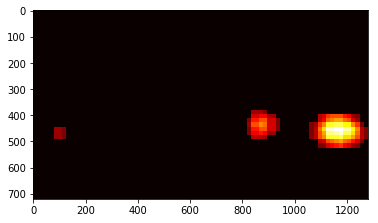

In [103]:
plt.imshow(heat,cmap="hot")
plt.savefig('thresholded_test_image.png')

In [104]:
labels = label(heat)

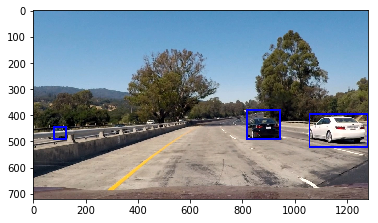

In [105]:
plt.imshow(draw_labelled_boxes(test_image,labels,heat))
plt.savefig('final_test_image_out.png')

## Video Process

In [106]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [107]:
def process_image(img):
    global clf
    global scaler
    bboxes = search_multi(img,[{"scale":1,"ystart":300,"ystop":600},{"scale":2,"ystart":300,"ystop":700}],clf,scaler)

    heat = add_heatmap(img,bboxes)
    heat = apply_thresh(heat,thresh=3)
    labels = label(heat)
    fimage = draw_labelled_boxes(img,labels,heat)
    
    return fimage

In [110]:
frame_number =0
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 155/1261 [29:58<3:57:55, 12.91s/it]


 25%|██▍       | 309/1261 [1:01:08<2:51:52, 10.83s/it]


 36%|███▌      | 457/1261 [1:27:40<2:23:44, 10.73s/it]


 48%|████▊     | 605/1261 [1:55:49<1:57:58, 10.79s/it]


 60%|█████▉    | 753/1261 [2:22:16<1:34:32, 11.17s/it]


 71%|███████▏  | 901/1261 [2:52:47<1:07:22, 11.23s/it]


 83%|████████▎ | 1052/1261 [3:22:47<40:08, 11.52s/it]


 95%|█████████▌| 1203/1261 [3:50:27<10:23, 10.75s/it]


100%|█████████▉| 1260/1261 [4:00:35<00:10, 10.68s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 4h 37s
